# Step 1: Import data from Repo and Merge to one Dataset

In [1]:
!pip install holidays
import pandas as pd
import holidays
import numpy as np

# Define the URLs for the additional datasets
kiwo_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv'
wetter_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv'
umsatzdaten_gekuerzt_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv'
ferien= '/workspaces/Team_Raum-3_BakerySalesPredictions/0_DataPreparation/ferien_schleswig_holstein_2012_2020.csv'

# Load the datasets   
kiwo = pd.read_csv(kiwo_url, delimiter=',')
wetter = pd.read_csv(wetter_url, delimiter=',')
umsatzdaten_gekuerzt = pd.read_csv(umsatzdaten_gekuerzt_url, delimiter=',')
ferien_df = pd.read_csv(ferien, delimiter=',')
# Merge datasets with a left join to retain all rows from wetter
wetter_umsatzdaten = pd.merge(wetter, umsatzdaten_gekuerzt, on="Datum", how="left")

# Add KiWo flag   
wetter_umsatzdaten['KiWo'] = wetter_umsatzdaten['Datum'].isin(kiwo['Datum']).astype(int)

# Convert 'Datum' to datetime and add a weekday column
wetter_umsatzdaten['Datum'] = pd.to_datetime(wetter_umsatzdaten['Datum'], errors='coerce')
wetter_umsatzdaten['Wochentag'] = wetter_umsatzdaten['Datum'].dt.day_name()
wetter_umsatzdaten['Is_Weekend'] = wetter_umsatzdaten['Datum'].dt.weekday.isin([5, 6]).astype(int)


# Read the ferien_schleswig_holstein_2012_2020.csv file
ferien_df = pd.read_csv('ferien_schleswig_holstein_2012_2020.csv')

# Convert Startdatum and Enddatum to datetime
ferien_df['Startdatum'] = pd.to_datetime(ferien_df['Startdatum'], format='%d.%m.%Y')
ferien_df['Enddatum'] = pd.to_datetime(ferien_df['Enddatum'], format='%d.%m.%Y')

# Create a new column in the existing DataFrame for Ferien
wetter_umsatzdaten['Ferien'] = None

# Convert the date column in the existing DataFrame to datetime if not already
wetter_umsatzdaten['Datum'] = pd.to_datetime(wetter_umsatzdaten['Datum'])

# Iterate through the ferien_df and update the Ferien column in existing_df
for index, row in ferien_df.iterrows():
    mask = (wetter_umsatzdaten['Datum'] >= row['Startdatum']) & (wetter_umsatzdaten['Datum'] <= row['Enddatum'])
    wetter_umsatzdaten.loc[mask, 'Ferien'] = row['Ferienart']
    
# Add a new column 'Is_Ferien' to the wetter_umsatzdaten dataframe
wetter_umsatzdaten['Is_Ferien'] = wetter_umsatzdaten['Ferien'].apply(lambda x: 1 if pd.notna(x) else 0)

print(wetter_umsatzdaten.head())
# Merge the datasets
#wetter_umsatzdaten_kiwo = pd.merge(wetter_umsatzdate, wetter_umsatzdaten, on="Datum", how="left")
# Convert the 'Datum' column to datetime
wetter_umsatzdaten['Datum'] = pd.to_datetime(wetter_umsatzdaten['Datum'])

# Define the range of years
years = range(2012, 2019 + 1)

# Create a list to store the holidays
holidays_sh = []

# Loop through each year and get the holidays for Schleswig-Holstein
for year in years:
    for date, name in holidays.Germany(years=year, state='SH').items():
        holidays_sh.append((date, name))

# Create a set of holiday dates
holiday_dates = set(date for date, name in holidays_sh)

# Add a new column 'Holiday' to the wetter_umsatzdaten dataframe
wetter_umsatzdaten['Holiday'] = wetter_umsatzdaten['Datum'].apply(lambda x: 1 if pd.to_datetime(x).date() in holiday_dates else 0)

# Replace NaN in Umsatz with 0
wetter_umsatzdaten['Umsatz'] = wetter_umsatzdaten['Umsatz'].fillna(0)

# Replace NaN in Warengruppe with 0
wetter_umsatzdaten['Warengruppe'] = wetter_umsatzdaten['Warengruppe'].fillna(0).astype(int)

# Identify rows where Warengruppe is 0
rows_with_zero_warengruppe = wetter_umsatzdaten[wetter_umsatzdaten['Warengruppe'] == 0]

# Create an empty list to store the expanded rows
expanded_rows = []

# For each row with Warengruppe = 0, create 6 copies with Warengruppe values from 1 to 6
for _, row in rows_with_zero_warengruppe.iterrows():
    for warengruppe_value in range(1, 7):  # For Warengruppe 1 to 5
        new_row = row.copy()  # Copy the original row
        new_row['Warengruppe'] = warengruppe_value  # Update the Warengruppe
        expanded_rows.append(new_row)  # Add the new row to the list

# Convert the list of expanded rows to a DataFrame
expanded_df = pd.DataFrame(expanded_rows)

# Remove the original rows with Warengruppe = 0 from the dataframe
wetter_umsatzdaten = wetter_umsatzdaten[wetter_umsatzdaten['Warengruppe'] != 0]

# Concatenate the original dataframe (with the Warengruppe = 0 rows removed) and the expanded rows
wetter_umsatzdaten = pd.concat([wetter_umsatzdaten, expanded_df], ignore_index=True)

# Sort the dataframe by 'Datum' and 'Warengruppe'
wetter_umsatzdaten = wetter_umsatzdaten.sort_values(by=['Datum', 'Warengruppe']).reset_index(drop=True)

# Create a new column 'ID' to match the sample submission format (YYMMDDW)
wetter_umsatzdaten['id'] = (
    wetter_umsatzdaten['Datum'].dt.strftime('%y%m%d').astype(str) + 
    wetter_umsatzdaten['Warengruppe'].astype(str)
).astype(int)

# Print the first few rows to verify the new ID format
print(wetter_umsatzdaten[['Datum', 'Warengruppe', 'id']].head())

# Add a new column 'Bakery_Closed', initialized as NaN for all rows
wetter_umsatzdaten['Bakery_Closed'] = np.nan

# Identify the rows within the specified date range
date_range_mask = (wetter_umsatzdaten['Datum'] >= '2013-07-01') & (wetter_umsatzdaten['Datum'] <= '2017-12-27')

# For rows within the date range, set 'Bakery_Closed' to 1 if 'Umsatz' is 0, otherwise set it to 0
wetter_umsatzdaten.loc[date_range_mask, 'Bakery_Closed'] = wetter_umsatzdaten.loc[date_range_mask, 'Umsatz'].apply(lambda x: 1 if x == 0 else 0)

# Save merged dataset directly
wetter_umsatzdaten.to_csv("wetter_umsatzdaten_kiwo_hol_id.csv", index=False)

print("Merge complete. Data saved for subsequent processing.")
print(wetter_umsatzdaten.head())


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
       Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  id  \
0 2012-01-01         8.0      9.8250                   14        58.0 NaN   
1 2012-01-02         7.0      7.4375                   12         NaN NaN   
2 2012-01-03         8.0      5.5375                   18        63.0 NaN   
3 2012-01-04         4.0      5.6875                   19        80.0 NaN   
4 2012-01-05         6.0      5.3000                   23        80.0 NaN   

   Warengruppe  Umsatz  KiWo Ferien  Is_Ferien  
0          NaN     NaN     0   None          0  
1          NaN     NaN     0   None          0  
2          NaN     NaN     0   None          0  
3          NaN     NaN     0   None          0  
4          NaN     NaN     0   None          0  
       Datum  Warengruppe       id
0 2012-01-01            1  1201011
1 2012-01-01            2  1201012
2 2012-01-01    

# Inspect data for missing values

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14028 entries, 0 to 14027
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                14028 non-null  object 
 1   Bewoelkung           13968 non-null  float64
 2   Temperatur           14028 non-null  float64
 3   Windgeschwindigkeit  14028 non-null  int64  
 4   Wettercode           10441 non-null  float64
 5   id                   14028 non-null  int64  
 6   Warengruppe          14028 non-null  int64  
 7   Umsatz               14028 non-null  float64
 8   KiWo                 14028 non-null  int64  
 9   Ferien               3266 non-null   object 
 10  Is_Ferien            14028 non-null  int64  
 11  Holiday              14028 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1.3+ MB
None
Shape of Data: (14028, 12)
Missing values per column:
Datum                      0
Bewoelkung                

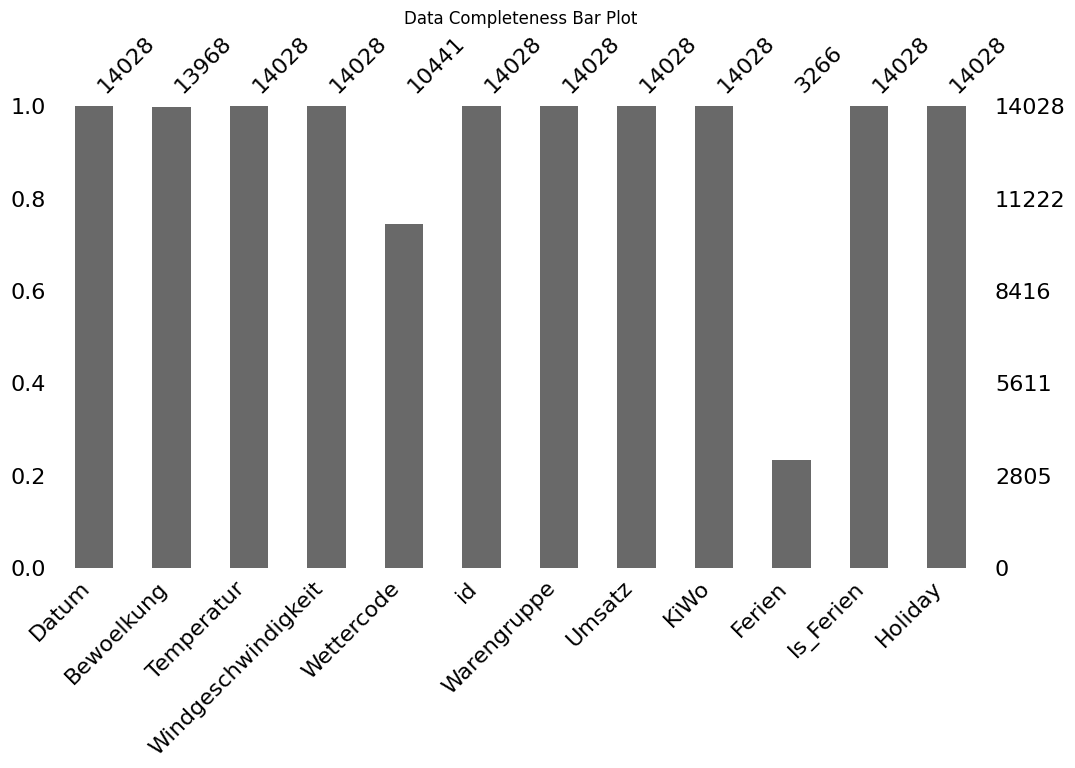

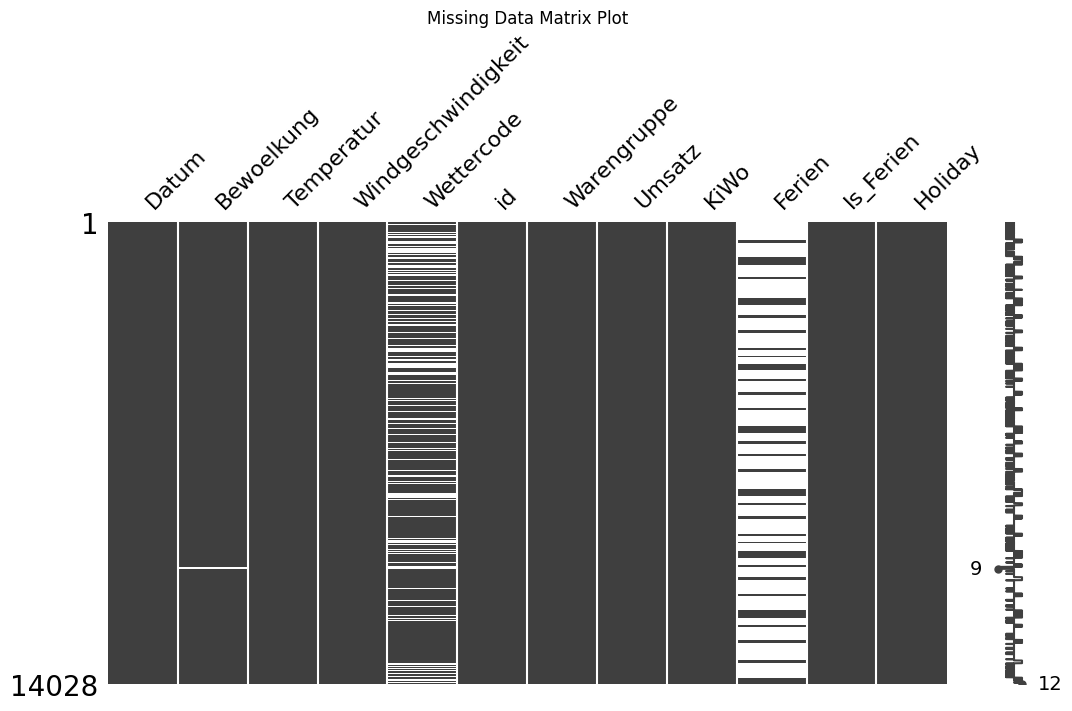

In [2]:
import missingno as msno
from matplotlib import pyplot as plt

wetter_umsatzdaten_kiwo = pd.read_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id.csv")

print("Data Overview:")
print(wetter_umsatzdaten_kiwo.info())
print("Shape of Data:", wetter_umsatzdaten_kiwo.shape)
print("Missing values per column:")
print(wetter_umsatzdaten_kiwo.isnull().sum())
#print(wetter_umsatzdaten.head())
#print(wetter_umsatzdaten.tail())

#Load the data
df = wetter_umsatzdaten_kiwo.copy()
print(df.info())

#barplot of complete data
msno.bar(df, figsize=(12, 6))
plt.title('Data Completeness Bar Plot')
plt.show()

#Visualize missing data for 'Bewoelkung'
msno.matrix(df, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()








# KNN Imputation for Bakery Closed

In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd

wetter_umsatzdaten = pd.read_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id.csv")

# Convert 'Datum' to datetime and keep the original 'Datum' column
wetter_umsatzdaten['Datum'] = pd.to_datetime(wetter_umsatzdaten['Datum'])  # Ensure 'Datum' is in datetime format

# Calculate the weekday from the original 'Datum' column
wetter_umsatzdaten['Weekday'] = wetter_umsatzdaten['Datum'].dt.dayofweek  # Extract the weekday (0=Monday, 6=Sunday)

# Convert 'Holiday' into numerical values if it is categorical
wetter_umsatzdaten['Holiday'] = wetter_umsatzdaten['Holiday'].astype(int)  # assuming it's already in binary form

# Now, prepare the data for KNN imputation
imputation_data = wetter_umsatzdaten[['Holiday','Weekday', 'Bakery_Closed']]

# Initialize the KNN imputer (with 5 neighbors, you can adjust this value)
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
imputed_values = knn_imputer.fit_transform(imputation_data[['Holiday', 'Weekday', 'Bakery_Closed']])

# Round imputed values of 'Bakery_Closed' to ensure binary (0 or 1)
imputed_values[:, 2] = imputed_values[:, 2].round()

# Assign the imputed values back to the original dataframe
wetter_umsatzdaten[['Holiday', 'Weekday', 'Bakery_Closed']] = imputed_values

# Now fill in the missing 'Bakery_Closed' values based on the imputed data
wetter_umsatzdaten['Bakery_Closed'] = wetter_umsatzdaten['Bakery_Closed'].fillna(wetter_umsatzdaten['Bakery_Closed'].mode()[0])

# Check the result and preserve the 'Datum', 'Holiday', 'Weekday', and 'Bakery_Closed'
print(wetter_umsatzdaten[['Datum', 'Holiday', 'Weekday', 'Bakery_Closed']].head(10))

# Save the dataframe to a CSV file
wetter_umsatzdaten.to_csv("wetter_umsatzdaten_kiwo_hol_id_Bakery_closed_imputed.csv", index=False)


# Create reference data frame with listwise deletion

Shape of Data after listwise deletion: (10441, 12)


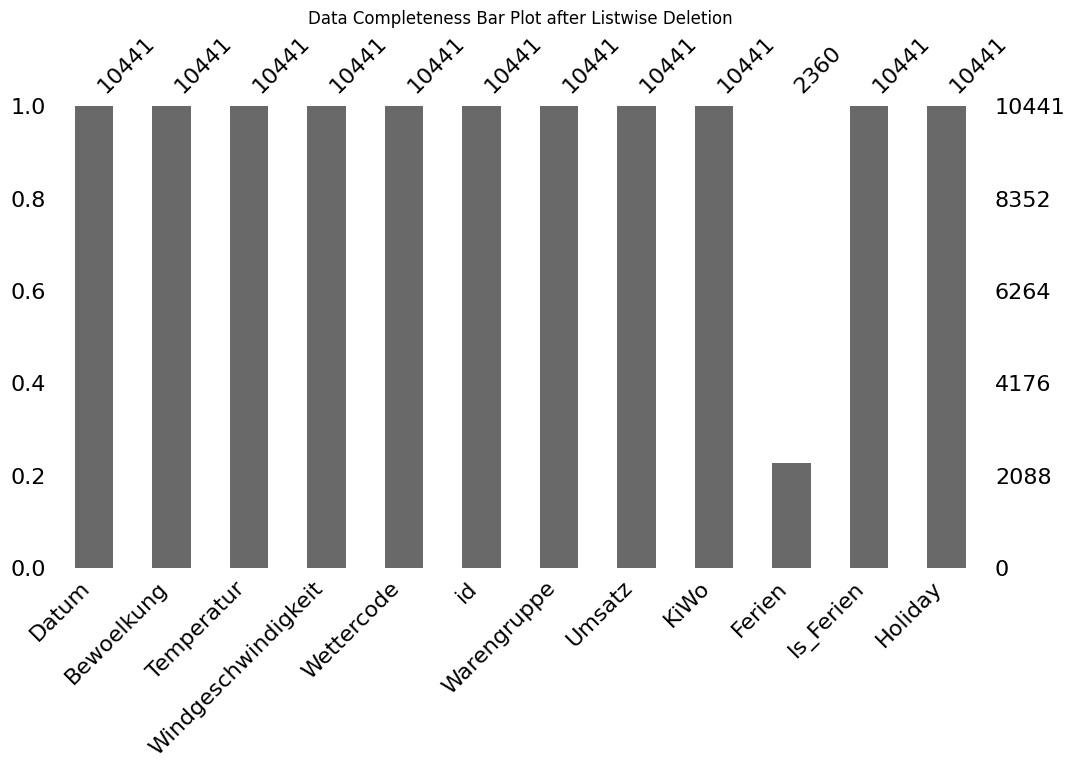

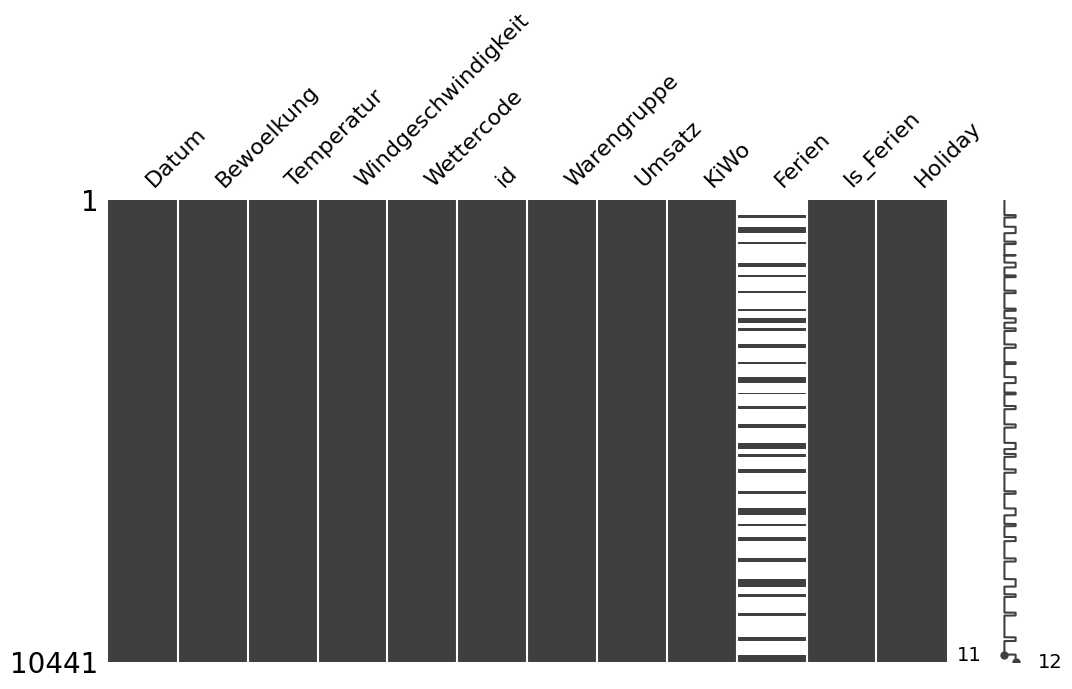

In [3]:
#load original data
df_for_listwise = pd.read_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id.csv")
#listwise deletion of rows with missing Bewoelkung values and missing Wettercodes values
df_listwise = df_for_listwise.dropna(subset=['Bewoelkung', 'Wettercode'])
print("Shape of Data after listwise deletion:", df_listwise.shape)
#visualize bar completeness plot of deleted matrix  
msno.bar(df_listwise, figsize=(12, 6))
plt.title('Data Completeness Bar Plot after Listwise Deletion')
plt.show()
#visualize matrix plot of deleted matrix
msno.matrix(df_listwise, figsize=(12, 6))
#save the data
df_listwise.to_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id_listwise.csv", index=False)



# Imputation of Bewoelkung

10472   2017-10-30
10473   2017-10-30
10474   2017-10-30
10475   2017-10-30
10476   2017-10-30
10477   2017-10-30
10478   2017-10-31
10479   2017-10-31
10480   2017-10-31
10481   2017-10-31
10482   2017-10-31
10483   2017-10-31
10484   2017-11-01
10485   2017-11-01
10486   2017-11-01
10487   2017-11-01
10488   2017-11-01
10489   2017-11-01
10490   2017-11-02
10491   2017-11-02
10492   2017-11-02
10493   2017-11-02
10494   2017-11-02
10495   2017-11-02
10496   2017-11-03
10497   2017-11-03
10498   2017-11-03
10499   2017-11-03
10500   2017-11-03
10501   2017-11-03
10502   2017-11-04
10503   2017-11-04
10504   2017-11-04
10505   2017-11-04
10506   2017-11-04
10507   2017-11-04
10508   2017-11-05
10509   2017-11-05
10510   2017-11-05
10511   2017-11-05
10512   2017-11-05
10513   2017-11-05
10514   2017-11-06
10515   2017-11-06
10516   2017-11-06
10517   2017-11-06
10518   2017-11-06
10519   2017-11-06
10520   2017-11-07
10521   2017-11-07
10522   2017-11-07
10523   2017-11-07
10524   2017

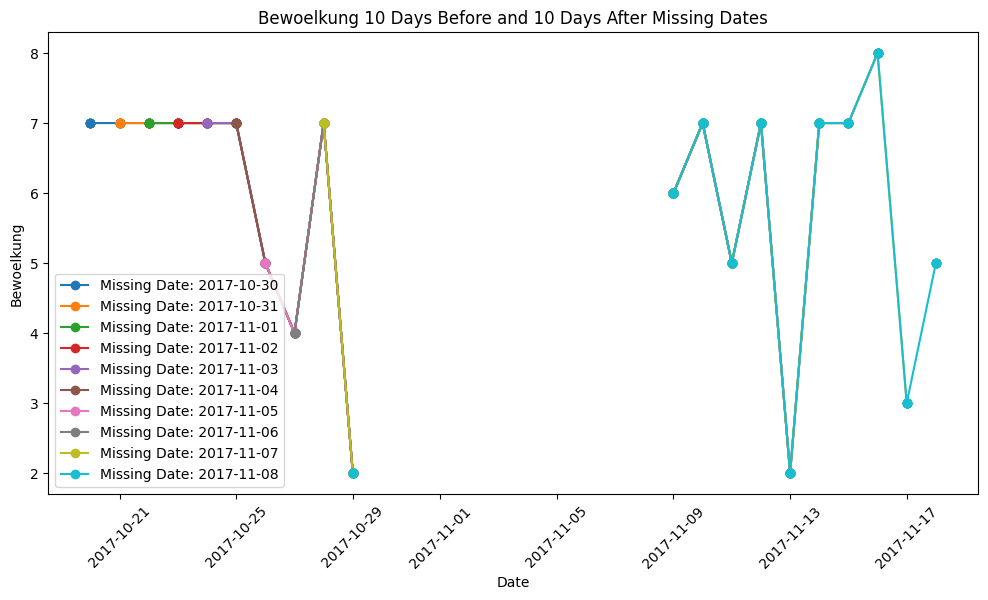

       Datum  Bewoelkung  Bewoelkung_Imputed
0 2012-01-01           8                   0
1 2012-01-01           8                   0
2 2012-01-01           8                   0
3 2012-01-01           8                   0
4 2012-01-01           8                   0
5 2012-01-01           8                   0
6 2012-01-02           7                   0
7 2012-01-02           7                   0
8 2012-01-02           7                   0
9 2012-01-02           7                   0


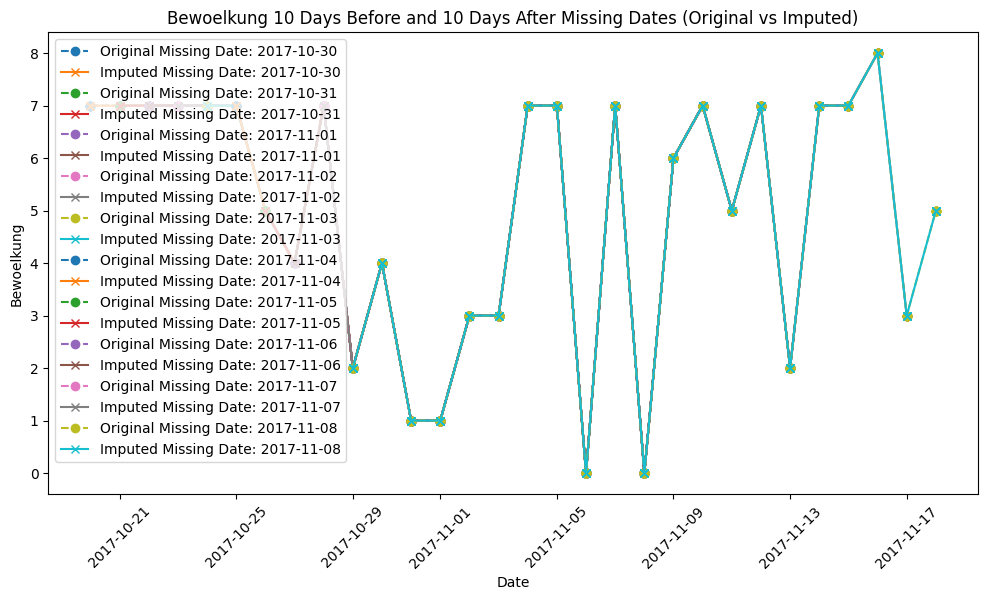

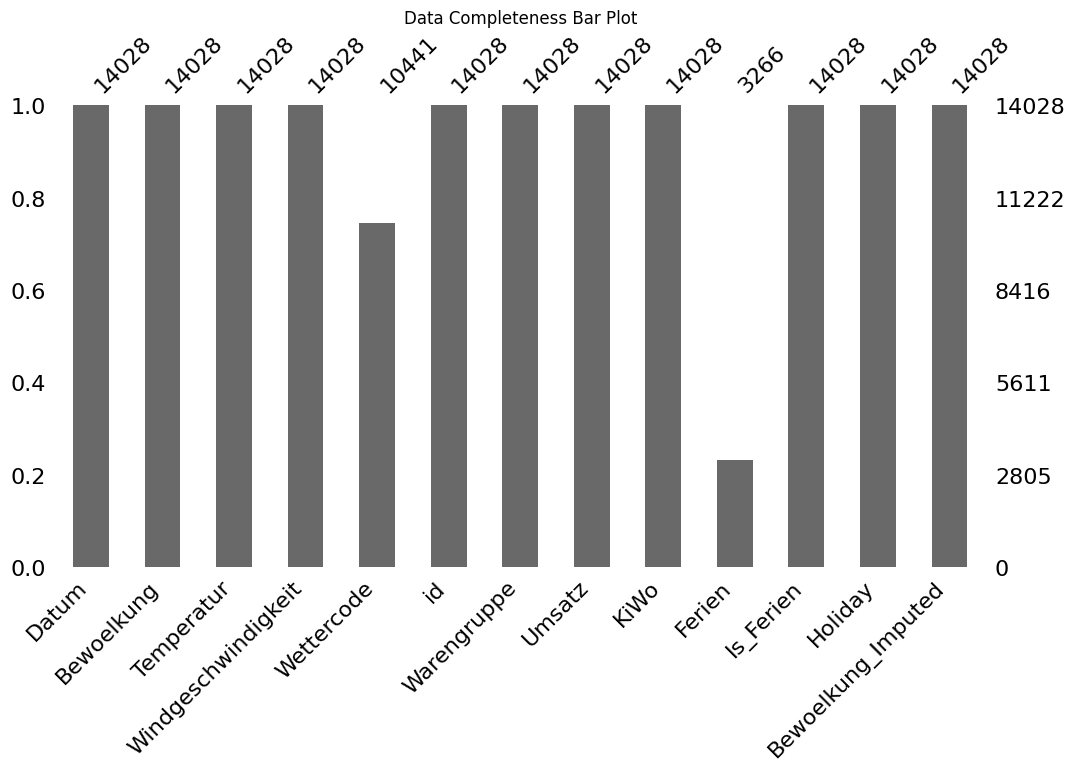

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import missingno as msno

df=pd.read_csv("wetter_umsatzdaten_kiwo_hol_id_Bakery_closed_imputed.csv")
# Ensure that 'Datum' is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

# Create a mask for the original missing values (before imputation)
missing_mask_bewoelkung = df['Bewoelkung'].isnull()

# Extract dates with missing 'Bewoelkung' values
missing_bewoelkung_dates = df[df['Bewoelkung'].isnull()]['Datum']
print(missing_bewoelkung_dates)

# Convert to datetime, though it should already be in the correct format
missing_bewoelkung_dates = pd.to_datetime(missing_bewoelkung_dates)

# Extract the unique missing dates
unique_missing_dates = missing_bewoelkung_dates.unique()

# Create a figure and axis for plotting the 'Bewoelkung' values before imputation
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each missing date
for missing_date in unique_missing_dates:
    missing_date = pd.to_datetime(missing_date)
    start_date = missing_date - pd.Timedelta(days=10)
    end_date = missing_date + pd.Timedelta(days=10)
    
    date_range_df = df[(df['Datum'] >= start_date) & (df['Datum'] <= end_date)]
    
    ax.plot(date_range_df['Datum'], date_range_df['Bewoelkung'], marker='o', label=f'Missing Date: {missing_date.date()}')

ax.set_title('Bewoelkung 10 Days Before and 10 Days After Missing Dates')
ax.set_xlabel('Date')
ax.set_ylabel('Bewoelkung')
plt.xticks(rotation=45)
ax.legend()
plt.show()

# Select the columns to be used for KNN imputation
columns_for_imputation = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit']

# Create a copy of the dataframe with only the relevant columns
df_impute = df[columns_for_imputation].copy()

# Initialize the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
df_imputed = knn_imputer.fit_transform(df_impute)

# Update the original dataframe with the imputed values for 'Bewoelkung'
# Round the imputed values to integers
df['Bewoelkung'] = df_imputed[:, 0].round().astype(int)

# Create a mask for imputed values based on original missing values
df['Bewoelkung_Imputed'] = missing_mask_bewoelkung.astype(int)

# Verify the imputation and new column for imputed values
print(df[['Datum', 'Bewoelkung', 'Bewoelkung_Imputed']].head(10))

# Compare original vs imputed data for 'Bewoelkung'
fig, ax = plt.subplots(figsize=(12, 6))

for missing_date in unique_missing_dates:
    start_date = missing_date - pd.Timedelta(days=10)
    end_date = missing_date + pd.Timedelta(days=10)
    
    date_range_df = df[(df['Datum'] >= start_date) & (df['Datum'] <= end_date)]
    
    ax.plot(date_range_df['Datum'], date_range_df['Bewoelkung'], marker='o', linestyle='--', label=f'Original Missing Date: {missing_date.date()}')
    ax.plot(date_range_df['Datum'], date_range_df['Bewoelkung'], marker='x', linestyle='-', label=f'Imputed Missing Date: {missing_date.date()}')

ax.set_title('Bewoelkung 10 Days Before and 10 Days After Missing Dates (Original vs Imputed)')
ax.set_xlabel('Date')
ax.set_ylabel('Bewoelkung')
plt.xticks(rotation=45)
ax.legend()
plt.show()

# Bar plot for completeness of the data
msno.bar(df, figsize=(12, 6))
plt.title('Data Completeness Bar Plot')
plt.show()

# Save the data with imputed values
df.to_csv("wetter_umsatzdaten_kiwo_hol_id_bewoelkung_imputed.csv", index=False)


# Imputation for Wettercode

        Datum  Wettercode  Wettercode_Imputed
0  2012-01-01          58                   0
1  2012-01-01          58                   0
2  2012-01-01          58                   0
3  2012-01-01          58                   0
4  2012-01-01          58                   0
5  2012-01-01          58                   0
6  2012-01-02          21                   1
7  2012-01-02          21                   1
8  2012-01-02          21                   1
9  2012-01-02          21                   1
Statistics of the imputed column (Wettercode):
count    14028.000000
mean        34.454263
std         28.254206
min          0.000000
25%          5.000000
50%         21.000000
75%         61.000000
max         95.000000
dtype: float64
Statistics of the un-imputed column (Wettercode):
count    14028.000000
mean        34.453949
std         28.254419
min          0.000000
25%          5.000000
50%         21.000000
75%         61.000000
max         95.000000
Name: Wettercode, dtype: float

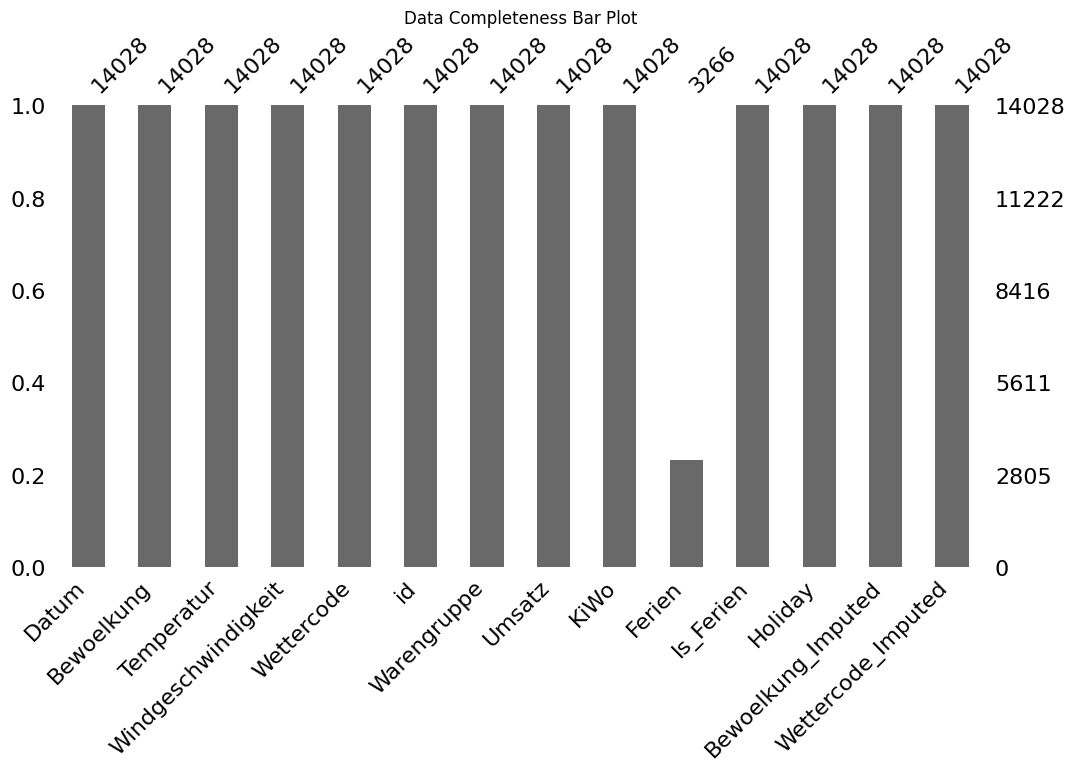

In [5]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

df=pd.read_csv("wetter_umsatzdaten_kiwo_hol_id_bewoelkung_imputed.csv")

# Create a mask for the original missing values for 'Wettercode' before imputation
missing_mask_wettercode = df['Wettercode'].isnull()

# Ensure that 'Wettercode' column is numeric if it's categorical
# We can use 'astype' to convert categorical values to numerical form.
# But instead of factorizing, directly treat the column as it is.
df['Wettercode'] = pd.to_numeric(df['Wettercode'], errors='coerce')

# Select the columns for KNN imputation
columns_for_imputation = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']

# Create a copy of the dataframe with only the relevant columns for imputation
df_impute = df[columns_for_imputation].copy()

# Initialize the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
df_imputed = knn_imputer.fit_transform(df_impute)

# Round the imputed values of 'Wettercode' to the nearest integer
df['Wettercode'] = np.round(df_imputed[:, 3]).astype(int)

# Create a new mask that tracks imputed values for 'Wettercode'
# If the value was originally missing, and it's now imputed, this will mark it as '1'
df['Wettercode_Imputed'] = missing_mask_wettercode.astype(int)

# Verify the imputation and the new column marking imputed values
print(df[['Datum', 'Wettercode', 'Wettercode_Imputed']].head(10))

# Statistics of the imputed 'Wettercode' column
imputed_stats_wettercode = pd.Series(df_imputed[:, 3]).describe()
print("Statistics of the imputed column (Wettercode):")
print(imputed_stats_wettercode)

# Statistics of the un-imputed 'Wettercode' column
unimputed_stats_wettercode = df['Wettercode'].describe()
print("Statistics of the un-imputed column (Wettercode):")
print(unimputed_stats_wettercode)

# Bar plot of data completeness
import matplotlib.pyplot as plt
import missingno as msno

msno.bar(df, figsize=(12, 6))
plt.title('Data Completeness Bar Plot')
plt.show()

# Save the data with imputed values
df.to_csv("wetter_umsatzdaten_kiwo_hol_id_bewoelkung_wettercode_imputed.csv", index=False)



# Step 2: Feature Engineering

In [6]:
# Load listwise deleted data
#wetter_umsatzdaten_kiwo = pd.read_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id_listwise.csv")

# Load the imputed data
wetter_umsatzdaten_kiwo = pd.read_csv("wetter_umsatzdaten_kiwo_hol_id_bewoelkung_wettercode_imputed.csv")
#convert Datum to datetime
wetter_umsatzdaten_kiwo['Datum'] = pd.to_datetime(wetter_umsatzdaten_kiwo['Datum'])

# Step 1: Inspect the data
print("Data Overview:")
print(wetter_umsatzdaten_kiwo.tail())
print("Shape of Data:", wetter_umsatzdaten_kiwo.shape)
print("Missing values per column:")
print(wetter_umsatzdaten_kiwo.isnull().sum())


# Add holiday category
def classify_main_ferien(ferien):
    if ferien == 'Sommerferien':
        return 1   # Sommerferien
    elif ferien == 'Weihnachtsferien':
        return 2    # Weihnachtsferien
    else:
        return 0   # no sommer or winterholidays

wetter_umsatzdaten_kiwo['Weihnachten_Sommer'] = wetter_umsatzdaten_kiwo['Ferien'].apply(classify_main_ferien)

# Add christmas sales flag
def christmas_sales_flag(date):
    if date.month == 12 and 1 <= date.day <= 24:
        return 1 # christmas sales
    else:
        return 0 # no christmas sales

wetter_umsatzdaten_kiwo['Christmas_Sales'] = wetter_umsatzdaten_kiwo['Datum'].apply(christmas_sales_flag)

# Add Sommerferien flag
def sommerferien_flag(ferien):
    if ferien == 'Sommerferien':
        return 1 #Sommerferien
    else:
        return 0 # no Sommerferien

wetter_umsatzdaten_kiwo['Sommerferien_Flag'] = wetter_umsatzdaten_kiwo['Datum'].apply(sommerferien_flag)


# Add a ferien tag
def classify_ferien(ferien):
    if ferien == 'Osterferien':
        return 1  # Osterferien
    elif ferien == 'Pfingstferien':	
        return 2  # Pfingstferien
    elif ferien == 'Sommerferien':
        return 3   # Sommerferien
    elif ferien == 'Herbstferien':
        return 4    # Herbstferien
    elif ferien == 'Weihnachtsferien':
        return 5    # Weihnachtsferien
    else:
        return 0   # no holidays

wetter_umsatzdaten_kiwo['Ferien_Category'] = wetter_umsatzdaten_kiwo['Ferien'].apply(classify_ferien)



# Add a temperature category
def classify_temperature(temp):
    if temp < 0:
        return -2  # Very Cold
    elif 0 <= temp <= 10:
        return -1  # Cold
    elif 10 < temp <= 20:
        return 1   # Warm
    else:
        return 2   # Very Warm

wetter_umsatzdaten_kiwo['Temperature_Category'] = wetter_umsatzdaten_kiwo['Temperatur'].apply(classify_temperature)


# Add a Beaufort scale categorization function
def classify_wind_speed_beaufort(wind_speed):
    if wind_speed <= 0.2:
        return 0  # Calm
    elif wind_speed <= 1.5:
        return 1  # Light Air
    elif wind_speed <= 3.3:
        return 2  # Light Breeze
    elif wind_speed <= 5.4:
        return 3  # Gentle Breeze
    elif wind_speed <= 7.9:
        return 4  # Moderate Breeze
    elif wind_speed <= 10.7:
        return 5  # Fresh Breeze
    elif wind_speed <= 13.8:
        return 6  # Strong Breeze
    elif wind_speed <= 17.1:
        return 7  # Near Gale
    elif wind_speed <= 20.7:
        return 8  # Gale
    elif wind_speed <= 24.4:
        return 9  # Strong Gale
    elif wind_speed <= 28.4:
        return 10  # Storm
    elif wind_speed <= 32.6:
        return 11  # Violent Storm
    else:
        return 12  # Hurricane

wetter_umsatzdaten_kiwo['Windgeschwindigkeit_Beaufort'] = wetter_umsatzdaten_kiwo['Windgeschwindigkeit'].apply(classify_wind_speed_beaufort)

#add a wind status
def classify_wind_status(wind_speed_beaufort):
    if wind_speed_beaufort <= 2:
        return 0  # Calm
    elif wind_speed_beaufort <= 4:
        return 1  # Light Air
    elif wind_speed_beaufort <= 6:
        return 2  # Light Breeze
    elif wind_speed_beaufort <= 8:
        return 3  # Gentle Breeze
    elif wind_speed_beaufort <= 10:
        return 4  # Moderate Breeze
    elif wind_speed_beaufort <= 12:
        return 5  # Fresh Breeze
    else:
        return 6  # Strong Breeze

wetter_umsatzdaten_kiwo['Wind_Status'] = wetter_umsatzdaten_kiwo['Windgeschwindigkeit_Beaufort'].apply(classify_wind_status)

# Add a column for Rain_Status based on Wettercode
def map_rain_status(wettercode):
    rain_status_mapping = {
        0: 0,
        20: 0,
        21: 0,
        61: 1,
        63: 1,
        65: 1,
        95: 2
    }
    return rain_status_mapping.get(wettercode, -1)  # Default to -1 for unknown codes

wetter_umsatzdaten_kiwo['Rain_Status'] = wetter_umsatzdaten_kiwo['Wettercode'].apply(map_rain_status)

#Add acolumn for Cloud_Status based on Bewölkung
def map_cloud_status(bewoelkung):
    if bewoelkung < 1:
        return 0  # sunny
    elif bewoelkung <= 3:
        return 1 # clear
    elif bewoelkung <= 6:
        return 2  # Partly Cloudy
    elif bewoelkung <= 7:
        return 3  # Cloudy
    else:
        return 4  # totally Cloudy

wetter_umsatzdaten_kiwo['Cloud_Status'] = wetter_umsatzdaten_kiwo['Bewoelkung'].apply(map_cloud_status)


# Perform one-hot encoding for 'Warengruppe'
warengruppe_encoded = pd.get_dummies(wetter_umsatzdaten_kiwo['Warengruppe'], prefix='Warengruppe')

# Convert the True/False values to 1/0
warengruppe_encoded = warengruppe_encoded.astype(int)

# Concatenate the one-hot encoded columns with the original dataframe
wetter_umsatzdaten_kiwo = pd.concat([wetter_umsatzdaten_kiwo, warengruppe_encoded], axis=1)



# Dynamically create a list of feature columns
feature_columns = [
    'KiWo', 
    'Is_Weekend', 
    'Temperature_Category', 
    'Wind_Status', 
    'Rain_Status',
    'Cloud_Status',
    'Is_Ferien',
    #'Weihnachten_Sommer'
    'Holiday'
] + list(warengruppe_encoded.columns)

# Step 3: Save listwise Processed Data
#wetter_umsatzdaten_kiwo.to_csv("processed_data_deleted.csv", index=False)

#save imputed processed data
wetter_umsatzdaten_kiwo.to_csv("processed_data_imputed.csv", index=False)

# Save feature columns to a file for use in the modeling stage
with open("feature_columns.txt", "w") as f:
    f.write("\n".join(feature_columns))

print("Data preparation and characterization complete. Processed data and feature columns saved.")

Data Overview:
            Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
14023  2019-08-01           5     21.0625                    9          61   
14024  2019-08-01           5     21.0625                    9          61   
14025  2019-08-01           5     21.0625                    9          61   
14026  2019-08-01           5     21.0625                    9          61   
14027  2019-08-01           5     21.0625                    9          61   

            id  Warengruppe  Umsatz  KiWo        Ferien  Is_Ferien  Holiday  \
14023  1908012            2     0.0     0  Sommerferien          1        0   
14024  1908013            3     0.0     0  Sommerferien          1        0   
14025  1908014            4     0.0     0  Sommerferien          1        0   
14026  1908015            5     0.0     0  Sommerferien          1        0   
14027  1908016            6     0.0     0  Sommerferien          1        0   

       Bewoelkung_Imputed  Wettercode_Imp